#  Energy maps

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin

root_dir = "/home1/datawork/mdemol/GDP"

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster()
    w = cluster.scale(jobs=2)  # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.110:8787/status,
Dashboard: http://10.148.0.110:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.110:35438,Workers: 0
Dashboard: http://10.148.0.110:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


_______
# Energy map from spectra

In [3]:
zarr_argos = os.path.join(root_dir, "argos_geospectra_2.zarr")
zarr_gps = os.path.join(root_dir, "gps_geospectra_2.zarr")
dsg = xr.open_zarr(zarr_gps).persist()
dsa = xr.open_zarr(zarr_argos).persist()

In [4]:
dsg

<xarray.Dataset>
Dimensions:     (lon_bins: 180, lat_bins: 90, frequency: 1440)
Coordinates:
  * frequency   (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins    (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins    (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Data variables:
    E_aen       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_axy       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_ven       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_venw2     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxy       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxydiff   (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxyw2     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    nb_geobins  (lon_bins, lat_bins) int64 dask.array<chunksize=(180, 90), meta=np.ndarray>

In [5]:
print(dsg.nb_geobins.sum().compute())
print(dsa.nb_geobins.sum().compute())

<xarray.DataArray 'nb_geobins' ()>
array(51196)
<xarray.DataArray 'nb_geobins' ()>
array(159361)


In [6]:
def geo_plot(d_array, title="", legend="", **kwargs):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    d_array.rename(legend).plot(
        x="lon_bins", y="lat_bins", **kwargs, ax=ax, transform=ccrs.PlateCarree()
    )
    ax.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    ax.set_title(title, fontsize=15)
    gl = ax.gridlines(
        draw_labels=True,
    )

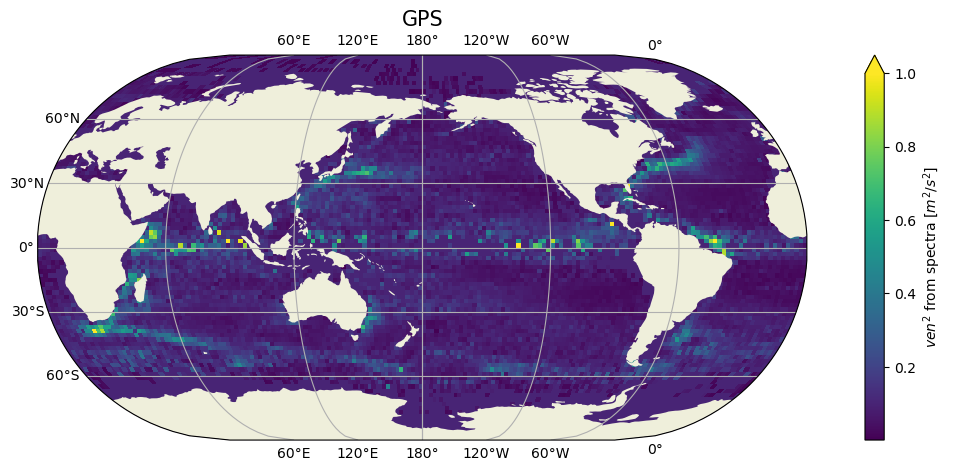

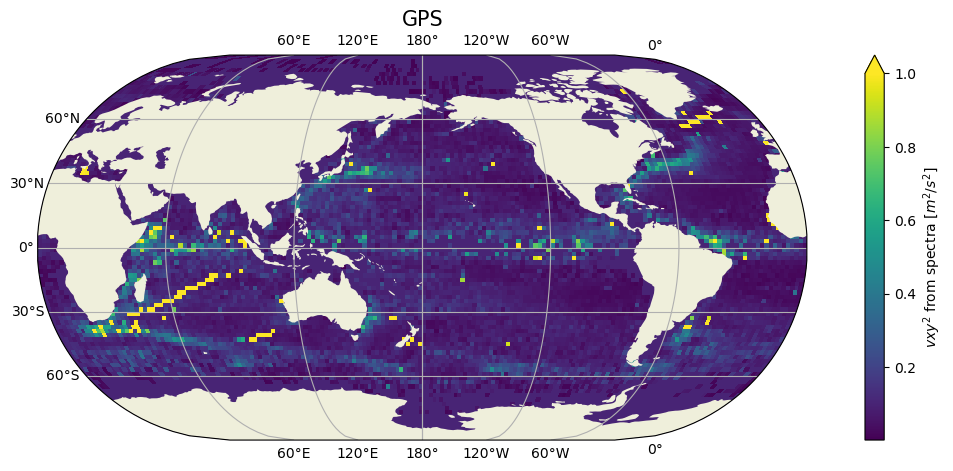

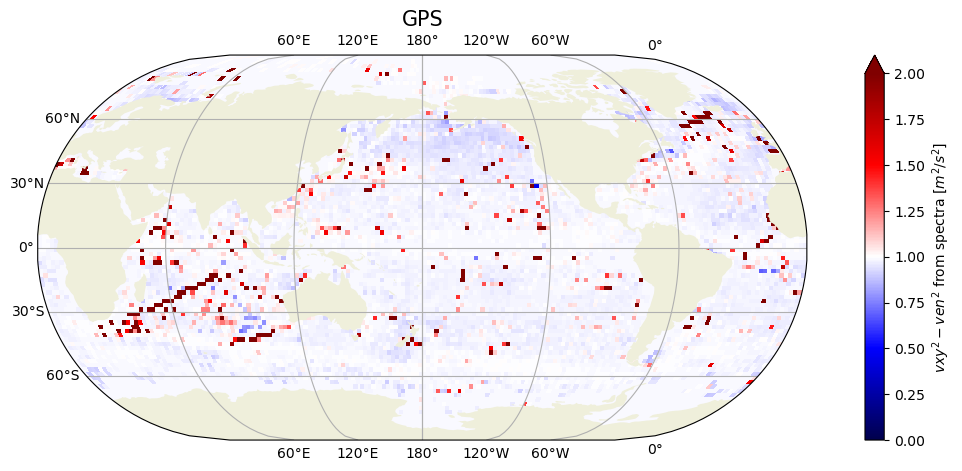

In [7]:
geo_plot(
    dsg.E_ven.integrate("frequency"),
    legend=r"$ven^2$ from spectra [$m^2/s^2$]",
    title="GPS",
    vmax=1,
)
geo_plot(
    dsg.E_vxy.integrate("frequency"),
    legend=r"$vxy^2$ from spectra [$m^2/s^2$]",
    title="GPS",
    vmax=1,
)
geo_plot(
    dsg.E_vxy.integrate("frequency") / dsg.E_ven.integrate("frequency"),
    legend=r"$vxy^2-ven^2$ from spectra [$m^2/s^2$]",
    title="GPS",
    cmap="seismic",
    vmin=0,
    vmax=2,
)

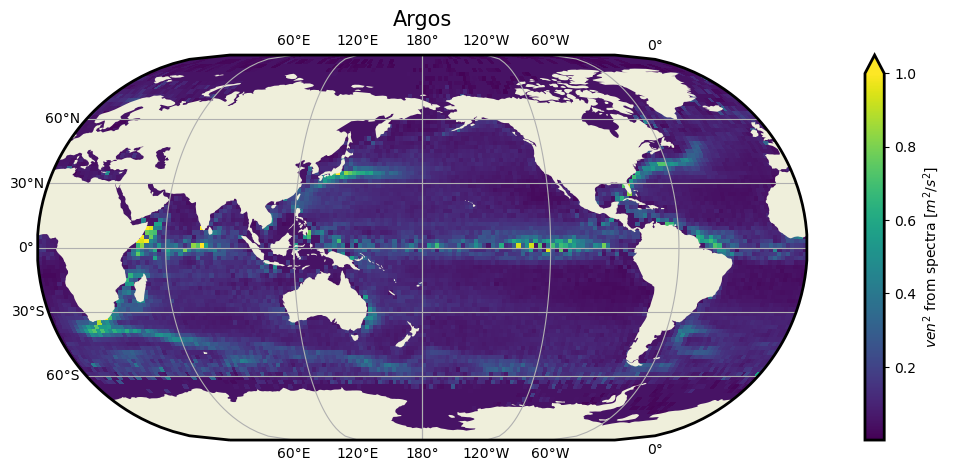

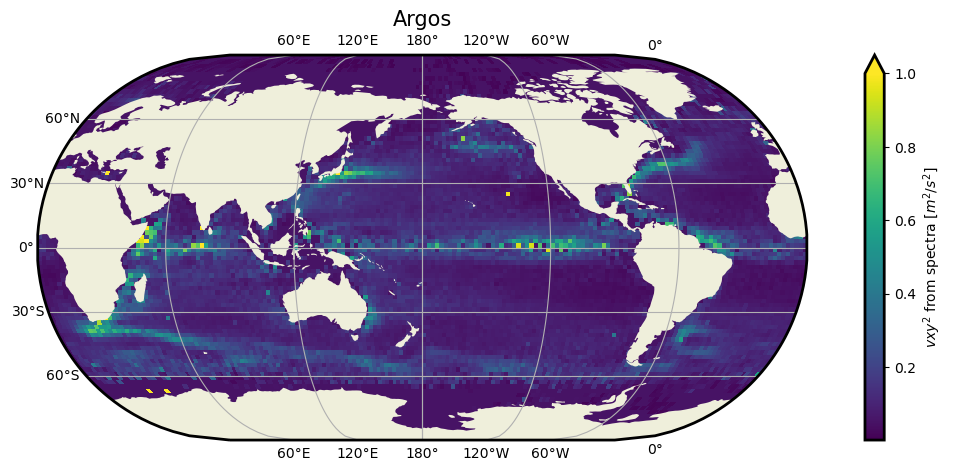

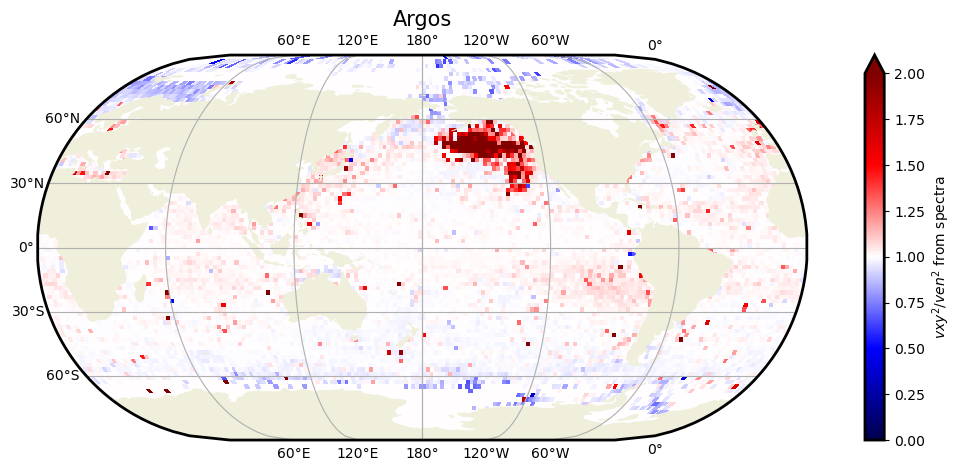

In [23]:
geo_plot(
    dsa.E_ven.integrate("frequency"),
    legend=r"$ven^2$ from spectra [$m^2/s^2$]",
    title="Argos",
    vmax=1,
)
geo_plot(
    dsa.E_vxy.integrate("frequency"),
    legend=r"$vxy^2$ from spectra [$m^2/s^2$]",
    title="Argos",
    vmax=1,
)
geo_plot(
    dsa.E_vxy.integrate("frequency") / dsa.E_ven.integrate("frequency"),
    legend=r"$vxy^2/ven^2$ from spectra",
    title="Argos",
    vmin=0,
    vmax=2,
    cmap="seismic",
)

___________
# Counts

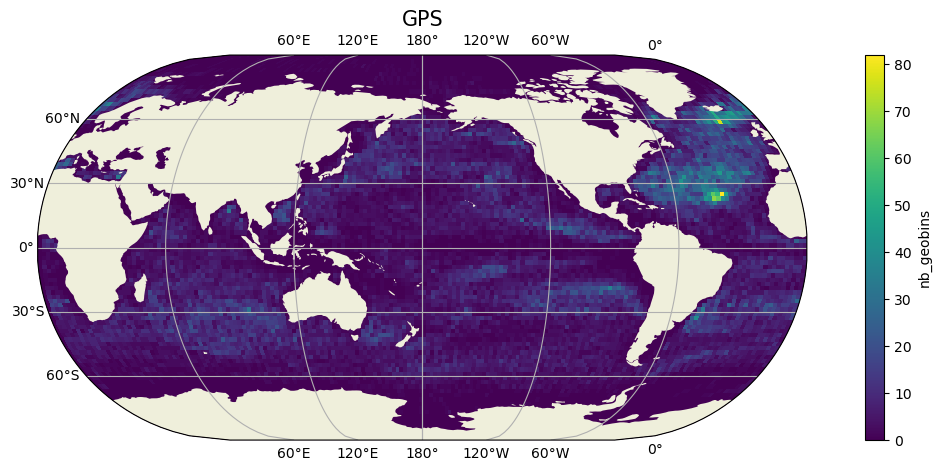

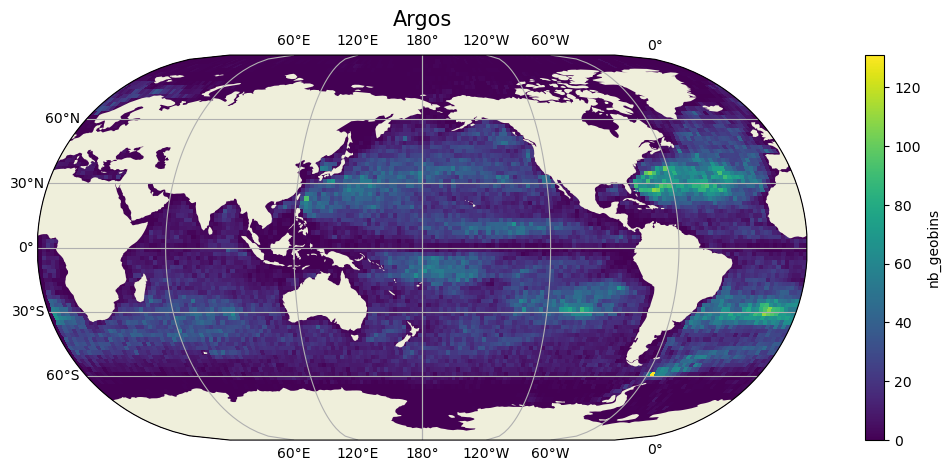

In [8]:
# nb counts
geo_plot(dsg.nb_geobins, legend="nb of points/bins", title="GPS")
geo_plot(dsa.nb_geobins, legend="nb of points/bins", title="Argos")

_______
# Computing root mean square

In [9]:
parquet_argos = os.path.join(root_dir, "argos_av_time.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time.parquet")
dfg = dd.read_parquet(parquet_gps).persist()
dfa = dd.read_parquet(parquet_argos).persist()

In [10]:
# bin geographically
def bins_geo(df, dl=2):
    lon_bins = np.arange(
        -180.0, 180.0 + dl, dl
    )  # CAUTION : add dl to upper bound (prevent from pb with last binning intervals)
    lat_bins = np.arange(-90, 90 + dl, dl)
    df["lon"] = (df["lon"] + 180) % 360 - 180
    df["lon_cut"] = df["lon"].map_partitions(pd.cut, bins=lon_bins).map(lambda x: x.mid)
    df["lat_cut"] = df["lat"].map_partitions(pd.cut, bins=lat_bins).map(lambda x: x.mid)


def norm_va(df):
    df["ven"] = np.sqrt(df["ve"] ** 2 + df["vn"] ** 2)
    df["ven2"] = df["ven"] ** 2
    df["vxy2"] = df["vxy"] ** 2


bins_geo(dfg)
bins_geo(dfa)
norm_va(dfg)
norm_va(dfa)

l_var = ["ven2", "vxy2"]
dsvg = (
    dfg[["lon_cut", "lat_cut"] + l_var]
    .groupby(["lon_cut", "lat_cut"])
    .mean()
    .reset_index()
    .rename(columns={"lon_cut": "lon_bins", "lat_cut": "lat_bins"})
    .compute()
    .to_xarray()
    .set_index(index=["lon_bins", "lat_bins"])
    .unstack()
)
dsva = (
    dfa[["lon_cut", "lat_cut"] + l_var]
    .groupby(["lon_cut", "lat_cut"])
    .mean()
    .reset_index()
    .rename(columns={"lon_cut": "lon_bins", "lat_cut": "lat_bins"})
    .compute()
    .to_xarray()
    .set_index(index=["lon_bins", "lat_bins"])
    .unstack()
)

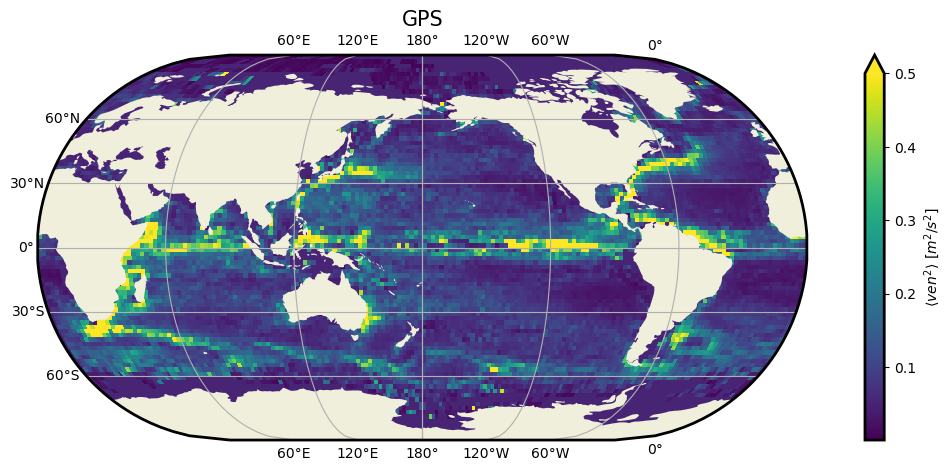

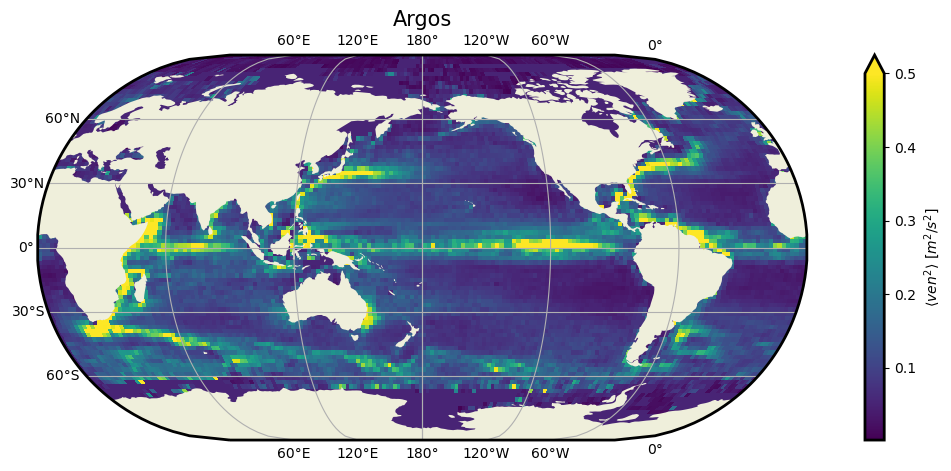

In [93]:
geo_plot(
    dsvg["ven2"],
    legend=r"$\langle ven^2 \rangle$ [$m^2/s^2$]",
    title="GPS",
)
geo_plot(
    dsva["ven2"],
    legend=r"$\langle ven^2 \rangle$ [$m^2/s^2$]",
    title="Argos",
)

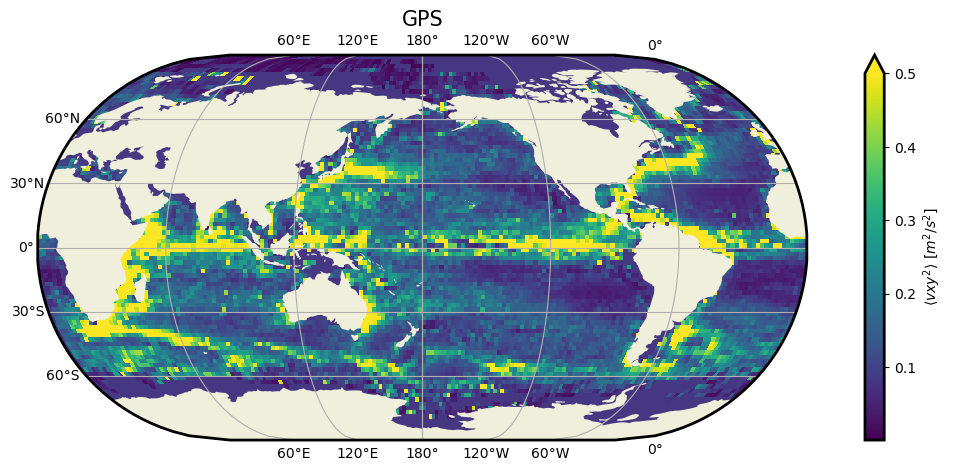

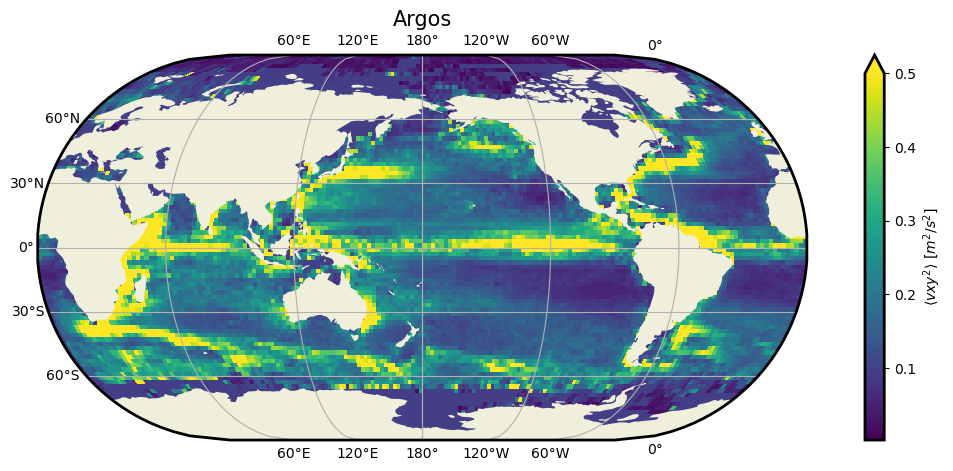

In [94]:
geo_plot(
    dsvg["vxy2"],
    legend=r"$\langle vxy^2 \rangle$ [$m^2/s^2$]",
    title="GPS",
)
geo_plot(
    dsva["vxy2"],
    legend=r"$\langle vxy^2 \rangle$ [$m^2/s^2$]",
    title="Argos",
)

_______
# Comparison

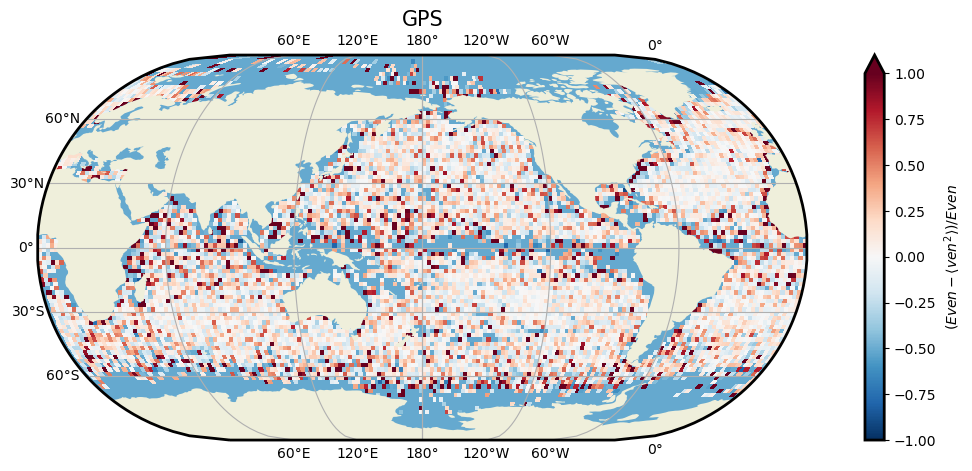

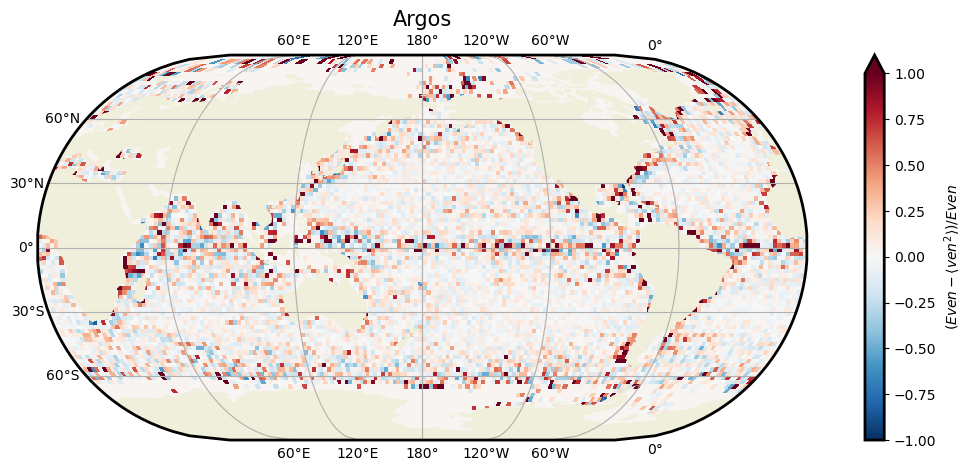

In [96]:
dsgven = dsg.E_ven.integrate("frequency")
dsaven = dsa.E_ven.integrate("frequency")

geo_plot(
    (dsvg["ven2"] - dsgven) / dsgven,
    legend=r"$(Even-\langle ven^2 \rangle)/Even$ ",
    title="GPS",
    vmax=1,
)
geo_plot(
    (dsva["ven2"] - dsaven) / dsaven,
    legend=r"$(Even-\langle ven^2 \rangle)/Even$ ",
    title="Argos",
    vmax=1,
)

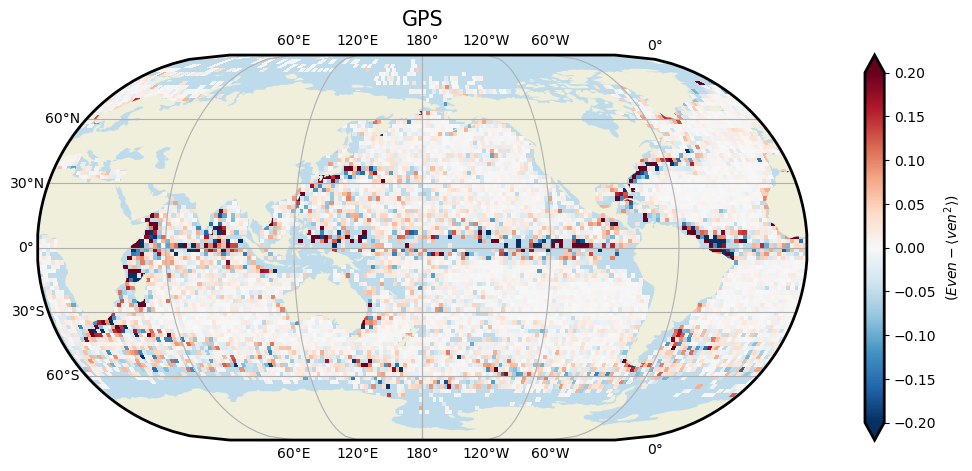

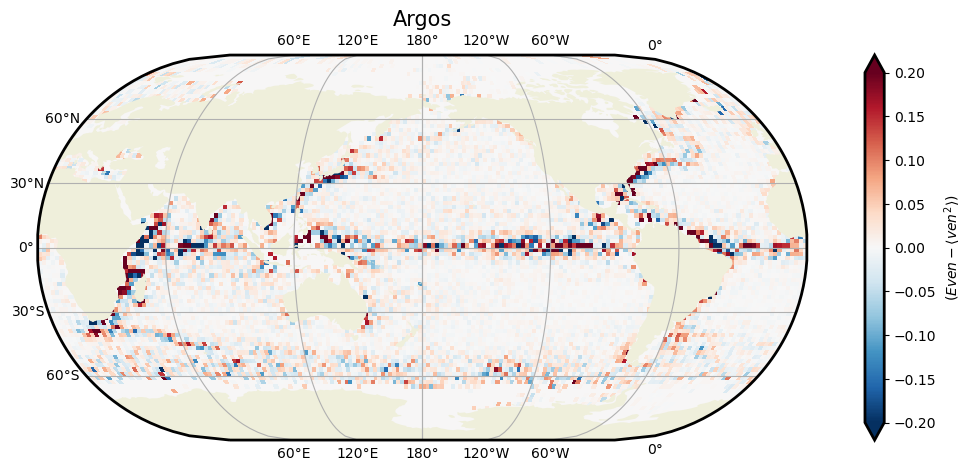

In [95]:
dsgven = dsg.E_ven.integrate("frequency")
dsaven = dsa.E_ven.integrate("frequency")

geo_plot(
    (dsvg["ven2"] - dsgven),
    legend=r"$(Even-\langle ven^2 \rangle)$ ",
    title="GPS",
    vmax=0.2,
)
geo_plot(
    (dsva["ven2"] - dsaven),
    legend=r"$(Even-\langle ven^2 \rangle)$ ",
    title="Argos",
    vmax=0.2,
)

In [11]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min